In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

<IPython.core.display.Javascript object>

# SILAC Experiments

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [69]:
#add back the description of the proteins
desc_dict = {}
path = 'TriTrypDB-32_TbruceiTREU927_AnnotatedProteins.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()#.replace('gene_product=','')
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc


In [228]:
'silac_Tb927.3.2610_dig05'
'label_free_crosslink_Tb927.3.2610'
'silac_Tb927.3.2610_dig03'
'20180820 TbdeAc2 labeel free data-1'

'20180820 TbdeAc2 labeel free data-1'

In [257]:
#list(df.columns)
list_df = []

In [258]:
#read data and log transform for plots
df = pd.read_csv('20180820 TbdeAc2 labeel free data-1/proteinGroups.txt',sep='\t')
df = clean(df)
df.head()
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df['Protein IDs' ]  ]  
df['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() if a in desc_dict else 'none' for a in n.split(';')]) for n in df['Gene_id_all' ]  ]  

df['Intensity DEAC2'] = df['Intensity DEAC2']+(df['Intensity DEAC2'][df['Intensity DEAC2']>0].min())
df['Intensity SM'] = df['Intensity SM']+(df['Intensity SM'][df['Intensity SM']>0].min())
df['exp_lf']= df['Intensity DEAC2'] / (df['Intensity DEAC2']+df['Intensity SM'])
df.set_index('Gene_id',inplace=True)
list_df.append(df['exp_lf'])
df[['exp_lf','Gene_desc']].sort_values('exp_lf').dropna().tail(5)
#list_df.append(df['exp_lf'])

removed  23 Only identified by site
tot  23  entries removed
---------------
removed  21 Reverse
tot  44  entries removed
---------------
removed  42 Potential contaminant
tot  86  entries removed
---------------


,exp_lf,Gene_desc
Gene_id,,
Tb927.7.3820,0.994675,"hypothetical protein, conserved"
Tb927.10.5820,0.994797,predicted RanGDP binding protein
Tb927.8.3710,0.996610,"exonuclease, putative"
Tb927.3.2610,0.997726,GPI inositol deacylase 2
Tb927.11.17650,0.999125,"variant surface glycoprotein (VSG), frameshift..."


In [259]:
from sklearn.preprocessing import MinMaxScaler
#mm = MinMaxScaler(feature_range=(0, 1))
#read data and log transform for plots
df = pd.read_csv('silac_Tb927.3.2610_dig05/proteinGroups.txt',sep='\t')
df = clean(df)
df.head()
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df['Protein IDs' ]  ]  
df['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() if a in desc_dict else 'none' for a in n.split(';')]) for n in df['Gene_id_all' ]  ]  

df['Intensity H'] = df['Intensity H']+df['Intensity H'][df['Intensity H']>0].min()
df['Intensity L'] = df['Intensity L']+df['Intensity L'][df['Intensity L']>0].min()
df['exp_dig5']= df['Intensity H'] / (df['Intensity L']+df['Intensity H'])

df.set_index('Gene_id',inplace=True)
list_df.append(df['exp_dig5'])
df[['exp_dig5', 'Gene_desc']].sort_values(by='exp_dig5').dropna().tail()

removed  47 Only identified by site
tot  47  entries removed
---------------
removed  19 Reverse
tot  66  entries removed
---------------
removed  53 Potential contaminant
tot  119  entries removed
---------------


,exp_dig5,Gene_desc
Gene_id,,
Tb927.11.11750,0.931683,"membrane-bound acid phosphatase, putative"
Tb927.6.1190,0.949696,"Plus-3 domain/Zinc finger, C3HC4 type (RING fi..."
Tb927.3.2610,0.953691,GPI inositol deacylase 2
Tb927.11.12440,0.958502,"Plus-3 domain/Zinc finger, C3HC4 type (RING fi..."
Tb927.8.3880,0.969977,"hypothetical protein, conserved"


In [260]:
#read data and log transform for plots
df = pd.read_csv('label_free_crosslink_Tb927.3.2610/proteinGroups.txt',sep='\t')
df = clean(df)
df.head()

df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df['Protein IDs' ]  ]  
df['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() if a in desc_dict else 'none' for a in n.split(';')]) for n in df['Gene_id_all' ]  ]  
df['exp_label_crosslink']= df['iBAQ 1']/df['iBAQ']
df['log10_score'] = np.log10(df['Score'])
df.set_index('Gene_id',inplace=True)

df['Intensity 1'] = df['Intensity 1']+df['Intensity 1'][df['Intensity 1']>0].min()
df['Intensity 2'] = df['Intensity 2']+df['Intensity 2'][df['Intensity 2']>0].min()

df['exp_lfc']= df['Intensity 1'] / (df['Intensity 1']+df['Intensity 2'])
list_df.append(df['exp_lfc'])
df[['exp_lfc', 'Gene_desc']].sort_values(by='exp_lfc').dropna().tail()
#list(df.columns)

removed  108 Only identified by site
tot  108  entries removed
---------------
removed  13 Reverse
tot  121  entries removed
---------------
removed  15 Potential contaminant
tot  136  entries removed
---------------


,exp_lfc,Gene_desc
Gene_id,,
Tb927.10.180,0.944066,"ATP synthase F1 subunit gamma protein, putative"
Tb927.11.11750,0.946844,"membrane-bound acid phosphatase, putative"
Tb927.4.3920,0.992509,"CRAL/TRIO domain containing protein, putative"
Tb927.9.13490,0.997226,"metallo-peptidase, Clan MG, Family M24"
Tb927.3.2610,0.999582,GPI inositol deacylase 2


In [261]:
#read data and log transform for plots
df = pd.read_csv('silac_Tb927.3.2610_dig03/proteinGroups.txt',sep='\t')
df = clean(df)
df.head()

df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df['Protein IDs' ]  ]  
df['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() if a in desc_dict else 'none' for a in n.split(';')]) for n in df['Gene_id_all' ]  ]  
df['logInt']=np.log10(df['Intensity'])
df['logRatio']=np.log2(df['Ratio H/L normalized'])
df['logScore']=np.log10(df['Score'])
#df['exp_dig03'] = mm.fit_transform(df[['logRatio']])
df['Intensity H'] = df['Intensity H']+df['Intensity H'][df['Intensity H']>0].min()
df['Intensity L'] = df['Intensity L']+df['Intensity L'][df['Intensity L']>0].min()
df['exp_dig03']= df['Intensity H'] / (df['Intensity L']+df['Intensity H'])

df.set_index('Gene_id',inplace=True)
list_df.append(df['exp_dig03'])
df[['exp_dig03', 'Gene_desc']].sort_values(by='exp_dig03').dropna().tail()

removed  59 Only identified by site
tot  59  entries removed
---------------
removed  17 Reverse
tot  76  entries removed
---------------
removed  34 Potential contaminant
tot  110  entries removed
---------------


,exp_dig03,Gene_desc
Gene_id,,
Tb927.4.3370,0.939001,"hypothetical protein, conserved"
Tb927.11.6890,0.943553,DNA repair and recombination helicase protein ...
Tb927.3.2610,0.955101,GPI inositol deacylase 2
Tb927.6.2850,0.976286,"ESAG8-associated protein, putative"
Tb927.9.8760,0.986971,"hypothetical protein, conserved"


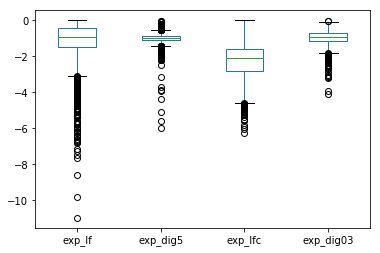

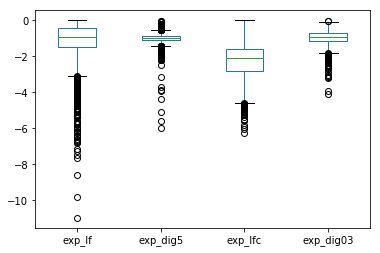

,exp_lf,exp_dig5,exp_lfc,exp_dig03,mean,desc,flag,flag2,flag3,flag4
Tb927.10.4200,0.896870,0.502237,0.260054,0.747126,0.624681,"hypothetical protein, conserved",0.896870,2.232481,1.394589,0.821998
Tb927.10.9980,0.970720,0.651215,0.403007,0.689296,0.670256,"hypothetical protein, conserved",0.970720,2.882989,1.932340,0.830008
Tb927.8.7780,0.893699,0.502237,0.260054,0.784700,0.643468,"hypothetical protein, conserved",0.893699,2.251301,1.448641,0.839199
Tb927.9.12890,0.950610,0.502237,0.727923,0.525748,0.626836,"hypothetical protein, conserved",0.950610,3.001147,1.881226,0.839267
Tb927.9.8820,0.928116,0.263801,0.260054,0.766280,0.515040,"hypothetical protein, conserved",0.928116,1.495870,0.770434,0.847198
Tb927.8.1090,0.989786,0.502237,0.260054,0.716778,0.609508,NPAPL,0.989786,1.962054,1.195887,0.853282
Tb927.7.700,0.917218,0.502237,0.260054,0.801081,0.651659,"hypothetical protein, conserved",0.917218,2.194423,1.430016,0.859150
Tb927.11.16010,0.792606,0.502237,0.927922,0.525748,0.659177,"hypothetical protein, conserved",0.927922,3.174705,2.092692,0.860264
Tb927.9.12510,0.899241,0.506608,0.830153,0.489519,0.668381,"ATP-dependent DEAD/H RNA helicase, putative",0.899241,3.128231,2.090849,0.864697
Tb927.10.11340,0.942203,0.502237,0.089229,0.799317,0.650777,"hypothetical protein, conserved",0.942203,1.726675,1.123680,0.870760


In [288]:
df = pd.concat(list_df,axis=1)
#df = ((df-df.mean())/df.std())
np.log2(df).plot(kind='box')
plt.show()

#df = df.multiply(np.mean(df.sum(axis=0))/df.sum(axis=0))
#df = df.divide(df.loc['Tb927.3.2610'])
np.log2(df).plot(kind='box')
plt.show()

df=df.fillna(df.mean())
#df=df/ (1/df.rank())
df['mean']=df.median(axis=1,skipna=True)#/ (df.isna().sum(axis=1)+1)

df.dropna(axis=0, how='all',inplace=True)
df['desc']=[desc_dict[n].replace('gene_product=','') for n in df.index.values]
df['flag']=df.iloc[:,0:4].max(axis=1)
df['flag2']=df['mean']/df.iloc[:,0:4].std(axis=1)
df['flag3']=df['flag2']*df['mean']

def make_top_mean(x,n=2):
    #print (x.nlargest(n=n))
    return x.nlargest(n=n).mean()


df['flag4'] = df.iloc[:,0:4].apply(make_top_mean, n=2, axis=1)
df[df['mean']>0.1].sort_values('flag4')

#df.rank().loc['Tb927.3.2610']

In [290]:
df[df['mean']>0.1].sort_values('flag4',ascending=False).to_csv('all_experiments_Tb927.3.2610.csv')